## Marcenko-Pastur Theorem

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neighbors._kde import KernelDensity

In [2]:
def mdPDF(sigma, T, N, pts):
    # Marcenko-Pastur PDF
    e_min = (sigma * (1 - np.sqrt(N / T)))**2
    e_max = (sigma * (1 + np.sqrt(N / T)))**2

    e_val = np.linspace(e_min, e_max, pts)

    pdf = (T / N) * np.sqrt((e_max - e_val) * (e_val - e_min)) / (2 * np.pi * e_val * sigma**2)
    
    pdf = pd.Series(pdf, index=e_val)

    return pdf

In [3]:
def getPCA(m):
    e_val, e_vec = np.linalg.eigh(m)
    idx = np.argsort(e_val)[::-1]
    e_val = e_val[idx]
    e_vec = e_vec[:, idx]
    e_val = np.diagflat(e_val)

    return e_val, e_vec

In [4]:
def fitKDE(obs, b_width = .25, kernel = 'gaussian', x = None):
    # Fit kernel to a series of obs, and derive the probability of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape) == 1:
        obs = np.reshape(obs, (-1, 1))
    
    kde = KernelDensity(kernel=kernel, bandwidth=b_width).fit(obs)

    if x is None:
        x = np.unique(obs)
    if len(x.shape) == 1:
        x = np.reshape(x, (-1, 1))

    log_prob = kde.score_samples(x)

    pdf = pd.Series(np.exp(log_prob), index=x.flatten())

    return pdf

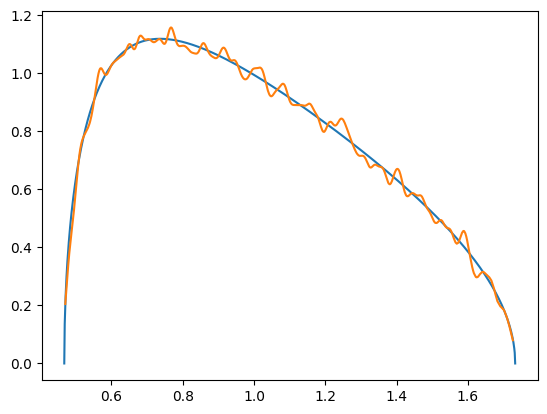

In [5]:
x = np.random.normal(size=(10000, 1000))
e_val0, e_vec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mdPDF(1., float(x.shape[0]), float(x.shape[1]), 1000)
pdf1 = fitKDE(np.diag(e_val0), b_width=0.01)

plt.plot(pdf0)
plt.plot(pdf1)
plt.show()